In [1]:
import torch
from torch import nn # nn stands for neural network
import matplotlib.pyplot as plt

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
weight = 0.3
bias = 0.9

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:] ,y[:]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900],
         [0.1000],
         [0.1100],
         [0.1200],
         [0.1300],
         [0.1400],
         [0.1500],
         [0.1600],
         [0.1700],
         [0.1800],
         [0.1900],
         [0.2000],
         [0.2100],
         [0.2200],
         [0.2300],
         [0.2400],
         [0.2500],
         [0.2600],
         [0.2700],
         [0.2800],
         [0.2900],
         [0.3000],
         [0.3100],
         [0.3200],
         [0.3300],
         [0.3400],
         [0.3500],
         [0.3600],
         [0.3700],
         [0.3800],
         [0.3900],
         [0.4000],
         [0.4100],
         [0.4200],
         [0.4300],
         [0.4400],
         [0.4500],
         [0.4600],
         [0.4700],
         [0.4800],
         [0.4900],
         [0.5000],
         [0.5100],
         [0.

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [5]:
# Move to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data.cpu().numpy(), train_labels.cpu().numpy(), c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data.cpu().numpy(), test_labels.cpu().numpy(), c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data.cpu().numpy(), predictions.cpu().detach().numpy(), c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

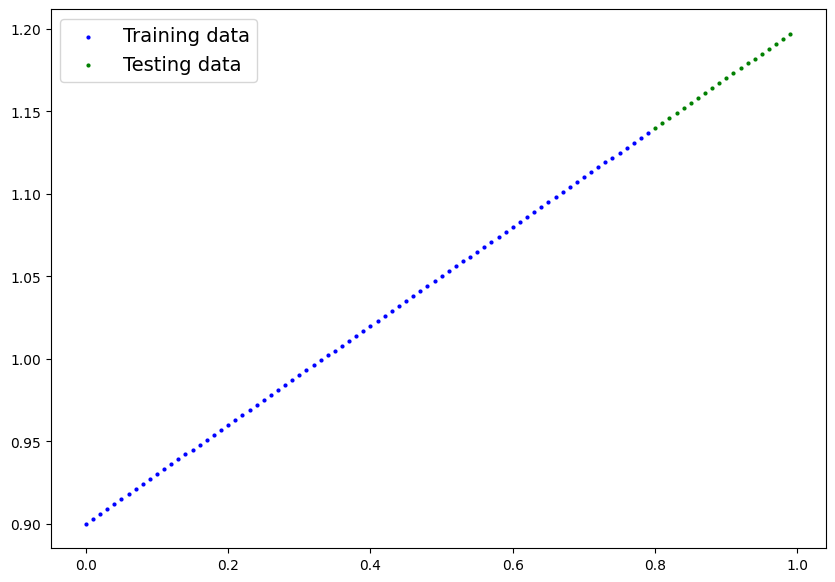

In [7]:
plot_predictions();

In [8]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [9]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
model = LinearRegressionModel().to(device)
print("Initial model parameters:")
print(model.state_dict())


Initial model parameters:
OrderedDict([('weights', tensor([0.2345], device='cuda:0')), ('bias', tensor([0.2303], device='cuda:0'))])


In [12]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of target model to optimize
                            lr=0.01)

In [14]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.cpu().detach().numpy())
            test_loss_values.append(test_loss.cpu().detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.6839940547943115 | MAE Test Loss: 0.7012526392936707 
Epoch: 10 | MAE Train Loss: 0.5683916807174683 | MAE Test Loss: 0.5659002661705017 
Epoch: 20 | MAE Train Loss: 0.45278921723365784 | MAE Test Loss: 0.4305478632450104 
Epoch: 30 | MAE Train Loss: 0.3371868133544922 | MAE Test Loss: 0.29519540071487427 
Epoch: 40 | MAE Train Loss: 0.22158442437648773 | MAE Test Loss: 0.15984301269054413 
Epoch: 50 | MAE Train Loss: 0.10598199814558029 | MAE Test Loss: 0.024490607902407646 
Epoch: 60 | MAE Train Loss: 0.034922435879707336 | MAE Test Loss: 0.06243162229657173 
Epoch: 70 | MAE Train Loss: 0.029798269271850586 | MAE Test Loss: 0.06705108284950256 
Epoch: 80 | MAE Train Loss: 0.026342665776610374 | MAE Test Loss: 0.06044179946184158 
Epoch: 90 | MAE Train Loss: 0.02291560173034668 | MAE Test Loss: 0.052793946117162704 
Epoch: 100 | MAE Train Loss: 0.01948852837085724 | MAE Test Loss: 0.045146066695451736 
Epoch: 110 | MAE Train Loss: 0.016062447801232338 | MA

In [16]:
model.eval()
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model(X_test)
y_preds

tensor([[1.1464],
        [1.1494],
        [1.1525],
        [1.1556],
        [1.1586],
        [1.1617],
        [1.1648],
        [1.1678],
        [1.1709],
        [1.1740],
        [1.1770],
        [1.1801],
        [1.1832],
        [1.1862],
        [1.1893],
        [1.1924],
        [1.1954],
        [1.1985],
        [1.2016],
        [1.2046]], device='cuda:0')

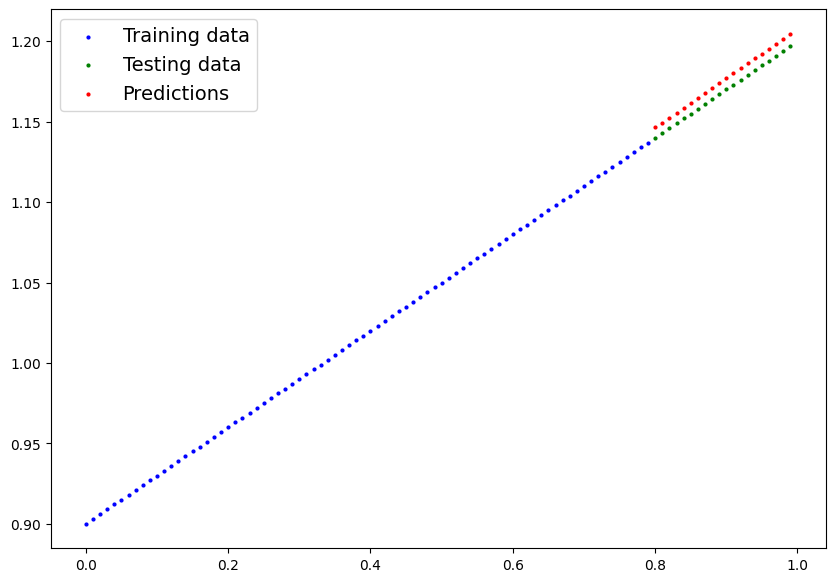

In [17]:
plot_predictions(predictions=y_preds)

In [18]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth
